In [102]:
import pandas as pd
import sys
import numpy as np
import string
import os
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.utils.estimator_checks import check_estimator
import matplotlib.pyplot as plt

	

from xgboost import XGBRegressor, XGBClassifier

In [2]:
os.path.abspath('..')
sys.path.append(os.path.abspath('..'))


In [34]:
import importlib

import transformers
from transformers.columns_setter_transformer import ColumnsSetterTransformer
from transformers.extract_set_column_transformer import ExtractSetColumnsTransformer
from transformers.select_transformer import SelectTransformer
from transformers.select_by_index_transformer import SelectByIndexTransformer
from transformers.one_hot_encoder_transformer import OneHotEncoderTransformer
from transformers.select_by_mask_transformer import SelectByMaskTransformer
from transformers.my_turns_transformation import MyTurnsTransformation
from transformers.classify_set_transformer import ClassifySetTransformer
importlib.reload(transformers)
importlib.reload(transformers.columns_setter_transformer)
importlib.reload(transformers.extract_set_column_transformer)
importlib.reload(transformers.select_transformer)
importlib.reload(transformers.select_by_index_transformer)
importlib.reload(transformers.one_hot_encoder_transformer)
importlib.reload(transformers.select_by_mask_transformer)
importlib.reload(transformers.my_turns_transformation)
importlib.reload(transformers.classify_set_transformer)



import functions
from functions.is_bot_extractor import IsBotExtarctor
importlib.reload(functions)
importlib.reload(functions.is_bot_extractor)

import builders
from builders.preprocessor_builder import PreprocessorBuilder
importlib.reload(builders)
importlib.reload(builders.preprocessor_builder)

import searcher
import searcher_results_orgenizer
from searcher_results_orgenizer import SearcherResultsOrgenizer
importlib.reload(searcher)
importlib.reload(searcher_results_orgenizer)







<module 'searcher_results_orgenizer' from 'c:\\Users\\Bina4\\Desktop\\Guy_hafifa\\scrabble\\searcher_results_orgenizer.py'>

In [4]:
games = pd.read_csv('../data/games.csv', index_col='game_id')
train = pd.read_csv('../data/train.csv', index_col='game_id')
turns = pd.read_csv('../data/turns.csv', index_col='game_id')


In [5]:
G_NAME = 'games'
T_NAME = 'turns'
DATA_NAME = 'train'

names = ['BetterBot', 'STEEBot', 'HastyBot']



tures = np.load('../feature_selection_consts/columns.npy', allow_pickle=True)
features.append('')

prePipe = Pipeline([
                    ('get_relavent_turns', SelectByIndexTransformer(train.index.unique(), target=T_NAME)),
                     ('get_relavent_games',  SelectByIndexTransformer(train.index.unique(), target=G_NAME)),
                     ('train_set_is_player', ExtractSetColumnsTransformer({'is_player': IsBotExtarctor(names, 'nickname', True)},
                                                                           src=DATA_NAME, dest=DATA_NAME)),
                     ('get_bot_rating', ExtractSetColumnsTransformer({'bot_rating': lambda train: train[~train['is_player']]['rating']},
                                                                      src=DATA_NAME, dest=G_NAME)),
                     ('get_bots_names', ExtractSetColumnsTransformer({'bot_name': lambda train: train[~train['is_player']]['nickname']},
                                                                     src=DATA_NAME, dest=G_NAME)),
                    ('data_drop_bot_rating', SelectByMaskTransformer('is_player', target=DATA_NAME)),
                    ])
preprocessor = PreprocessorBuilder(games, G_NAME, turns, T_NAME, prePipe).build()
n_games, n_turns, n_ratings = preprocessor.process(train, DATA_NAME)
t_turns = pd.read_csv('../data/fs_turns.csv', index_col='game_id') # MyTurnsTransformation().transform(n_turns)
n_data = n_games.merge(t_turns, left_index=True, right_index=True)



In [6]:
regressor_steps = [('extract_first', ColumnsSetterTransformer({'is_bot_first': IsBotExtarctor(names, name_col='first')})),
                   ('hot', OneHotEncoderTransformer({'time_control_name': games['time_control_name'].unique(),
                                                     'game_end_reason':  games['game_end_reason'].unique(),
                                                     'lexicon':  games['lexicon'].unique(),
                                                     'rating_mode':  games['rating_mode'].unique(),
                                                     'bot_name': names}
                                                        )),
                   ('select_col', SelectTransformer(features)),
                   ('xgb', XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10
                                        )),                                              
                   ]

regressor = Pipeline(regressor_steps)
regressor.fit(n_data, n_ratings)

Pipeline(steps=[('extract_first',
                 ColumnsSetterTransformer(columns={'is_bot_first': <functions.is_bot_extractor.IsBotExtarctor object at 0x000002088817B9D0>})),
                ('hot',
                 OneHotEncoderTransformer(columns={'bot_name': ['BetterBot',
                                                                'STEEBot',
                                                                'HastyBot'],
                                                   'game_end_reason': array(['STANDARD', 'RESIGNED', 'TIME', 'CONSECUTIVE_ZEROES'], dtype=object),
                                                   'lexicon': array(['...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.17320508075688773, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=0, ...))])

In [165]:
prediction = pd.Series(regressor.predict(n_data), index=n_ratings.index)

In [90]:
mean_squared_error(n_ratings, prediction, squared=False)

87.01702826366557

In [203]:
abs_error = np.abs(prediction - n_ratings)
error = prediction - n_ratings

In [10]:
abs_error.describe()

count    50410.000000
mean        59.767238
std         63.244919
min          0.000244
25%         12.078369
50%         40.841003
75%         86.747253
max        608.116089
dtype: float64

In [11]:
prediction.describe()

count    50410.000000
mean      1790.332886
std        204.806305
min       1058.774292
25%       1614.981903
50%       1816.444092
75%       1975.551117
max       2463.072510
dtype: float64

In [12]:
n_ratings.describe()

count    50410.000000
mean      1790.322674
std        229.662441
min       1033.000000
25%       1582.000000
50%       1818.000000
75%       1982.000000
max       2510.000000
Name: rating, dtype: float64

<Axes: >

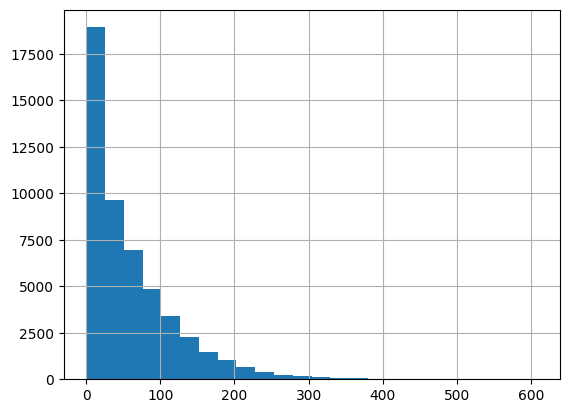

In [13]:
abs_error.hist(bins=24)

In [14]:
(abs_error < 100).sum() / abs_error.size

0.7974608212656219

In [15]:
(abs_error > 200).sum()

1936

In [16]:
n_games[abs_error>200].describe()

,winner,initial_time_seconds,increment_seconds,max_overtime_minutes,game_duration_seconds,bot_rating
count,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000,1936.000000
mean,0.316632,1204.927686,0.138430,1.133264,584.096847,2031.152893
std,0.471900,530.680899,2.732038,1.009418,281.676558,145.393588
min,-1.000000,180.000000,0.000000,0.000000,120.440364,1594.000000
25%,0.000000,960.000000,0.000000,1.000000,378.638119,1956.000000
50%,0.000000,1200.000000,0.000000,1.000000,521.300345,2033.000000
75%,1.000000,1200.000000,0.000000,1.000000,741.078766,2137.000000
max,1.000000,3600.000000,60.000000,10.000000,2087.298744,2341.000000


In [204]:
data = n_games.assign(**{'rating': n_ratings, 'abs_error': abs_error, 'pred': prediction, 'error': error})
data

,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_rating,bot_name,rating,abs_error,pred,error
game_id,,,,,,,,,,,,,,,,,
1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274,1637,BetterBot,1500,7.423950,1507.423950,7.423950
3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262,2071,BetterBot,1811,162.561646,1973.561646,162.561646
4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,1936,BetterBot,1473,85.788208,1387.211792,-85.788208
5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722,1844,STEEBot,1500,12.304077,1512.304077,12.304077
6,HivinD,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,426.950541,2143,STEEBot,2029,9.528320,2019.471680,-9.528320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72767,BetterBot,regular,TIME,0,2022-09-05 04:35:56,CSW21,3600,0,CASUAL,1,3669.988413,1952,BetterBot,1395,22.964478,1417.964478,22.964478
72770,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,3662.659287,2237,HastyBot,1332,56.554321,1275.445679,-56.554321
72771,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,236.133634,1614,HastyBot,1500,2.089111,1502.089111,2.089111


In [114]:
data['pred'].describe()

count    50410.000000
mean      1790.332886
std        204.806305
min       1058.774292
25%       1614.981903
50%       1816.444092
75%       1975.551117
max       2463.072510
Name: pred, dtype: float64

In [115]:
data['rating'].describe()

count    50410.000000
mean      1790.322674
std        229.662441
min       1033.000000
25%       1582.000000
50%       1818.000000
75%       1982.000000
max       2510.000000
Name: rating, dtype: float64

In [89]:
data['error'].describe()

count    50410.000000
mean        59.767238
std         63.244919
min          0.000244
25%         12.078369
50%         40.841003
75%         86.747253
max        608.116089
Name: error, dtype: float64

In [87]:
data[data['rating'] > 1600]['error'].describe()

count    36798.000000
mean        65.410328
std         57.876592
min          0.000244
25%         22.108826
50%         49.370605
75%         92.476471
max        572.370117
Name: error, dtype: float64

In [93]:
data[(data['rating'] < 1600)]['error'].describe()

count    13561.000000
mean        44.472619
std         73.809014
min          0.000366
25%          1.683594
50%          7.133179
75%         59.451660
max        608.116089
Name: error, dtype: float64

In [92]:
data[(data['rating'] < 1600) & (data['rating'] > 1400)]['error'].describe()

count    12285.000000
mean        37.185688
std         66.287334
min          0.000366
25%          1.506226
50%          4.963867
75%         46.595093
max        595.853027
Name: error, dtype: float64

In [17]:
(n_ratings < 1600).astype(int)

game_id
1        1
3        0
4        1
5        1
6        0
        ..
72767    1
72770    1
72771    1
72772    1
72773    0
Name: rating, Length: 50410, dtype: int32

<Axes: xlabel='rating', ylabel='error'>

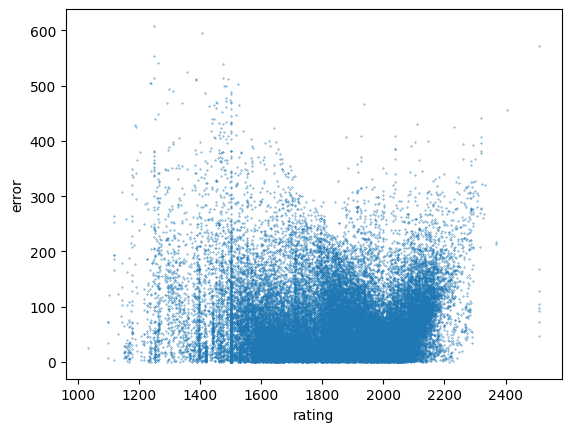

In [96]:
data.plot.scatter('rating', 'error', 0.1)

In [99]:
cats = ['winner', 'time_control_name', 'game_end_reason', 'lexicon', 'rating_mode',
        'bot_name', 'initial_time_seconds', 'increment_seconds', 'max_overtime_minutes']

In [119]:
mask.count()

50410

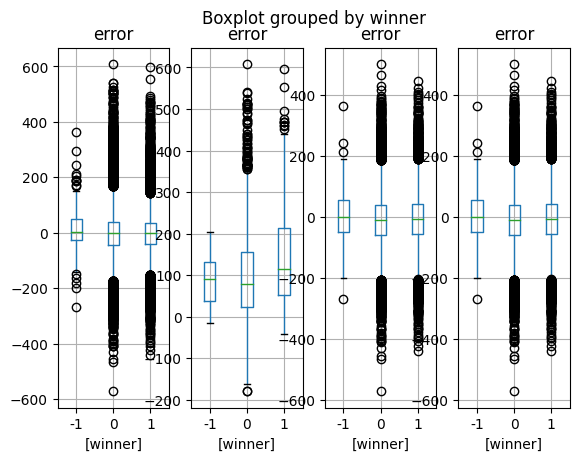

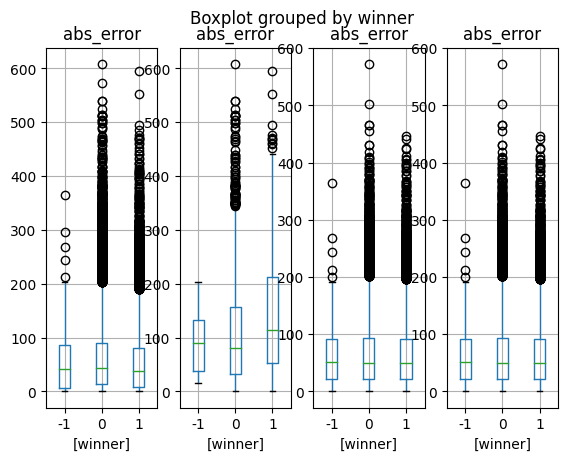

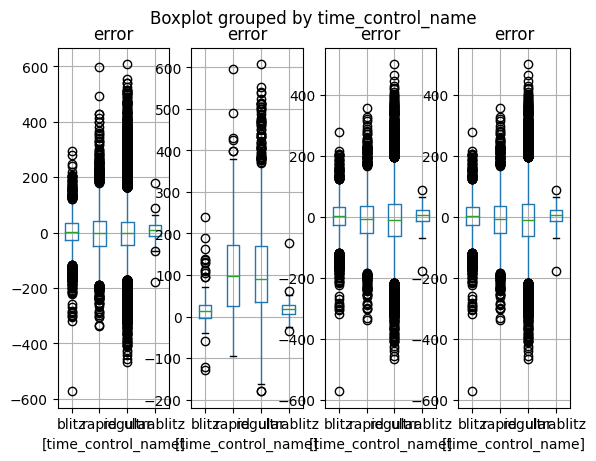

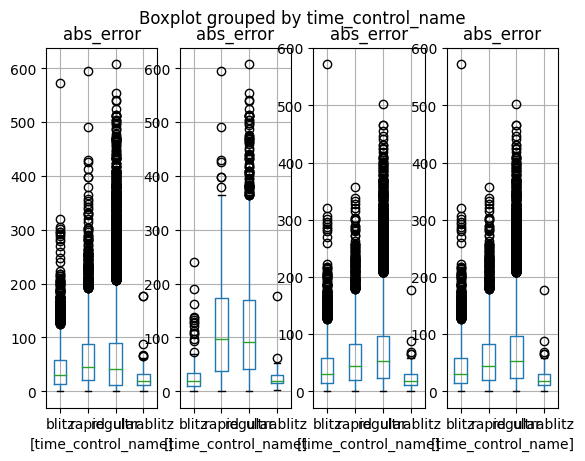

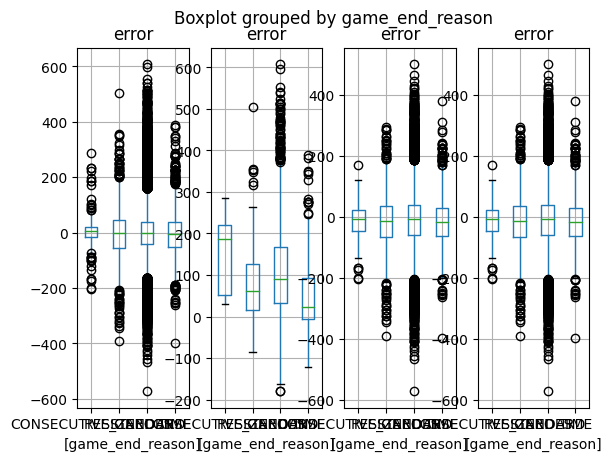

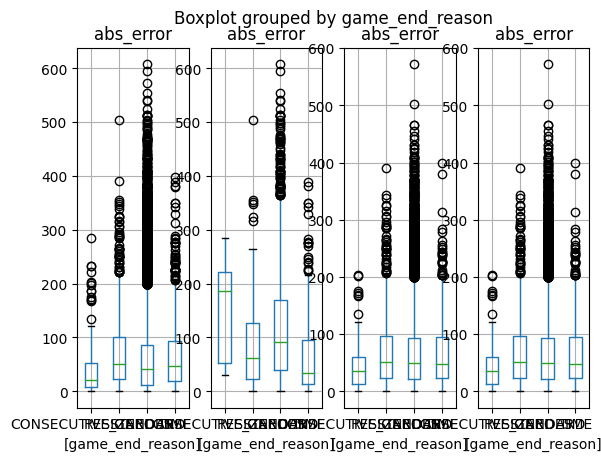

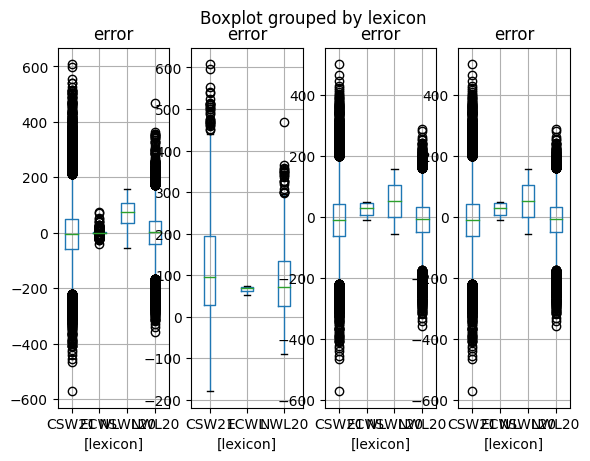

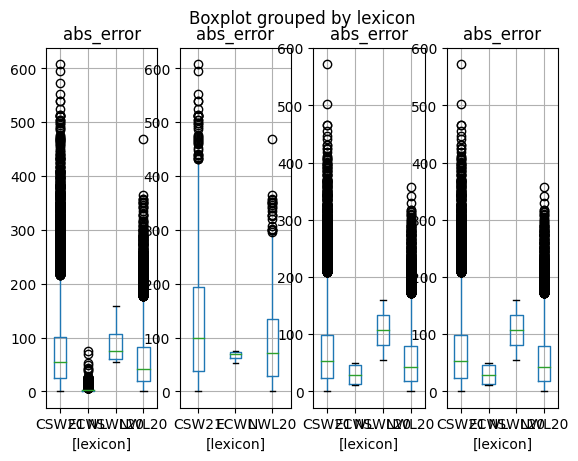

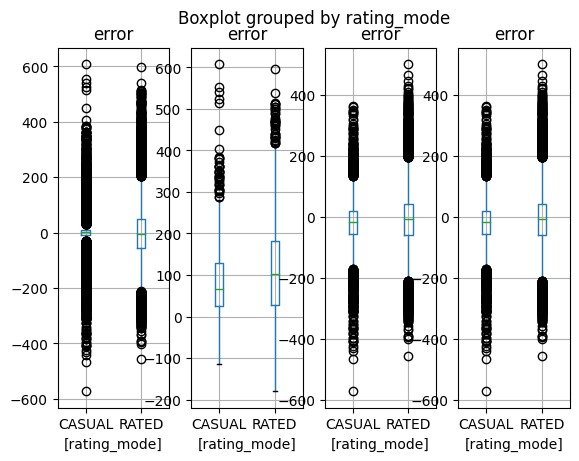

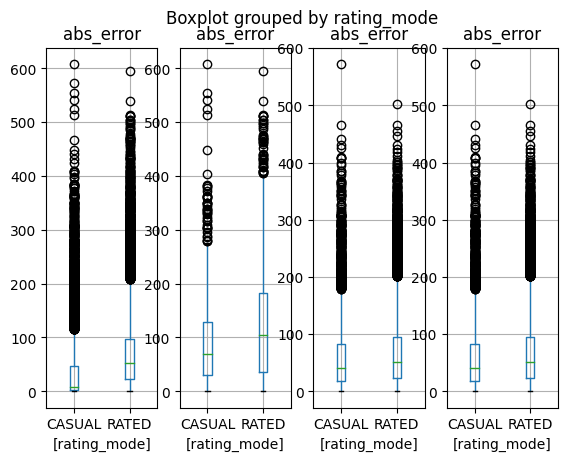

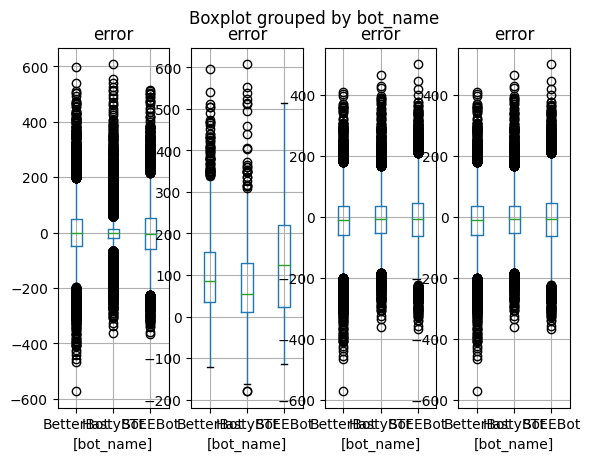

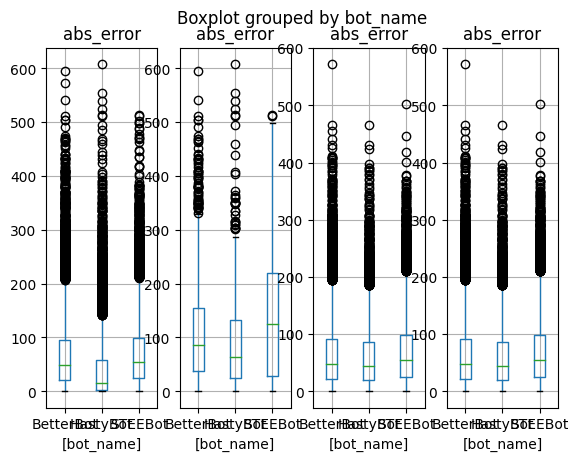

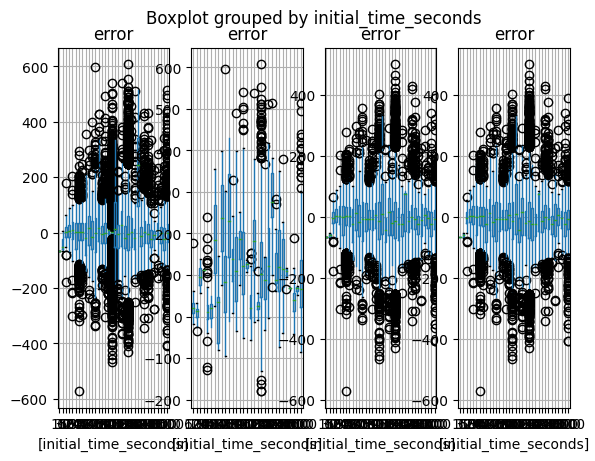

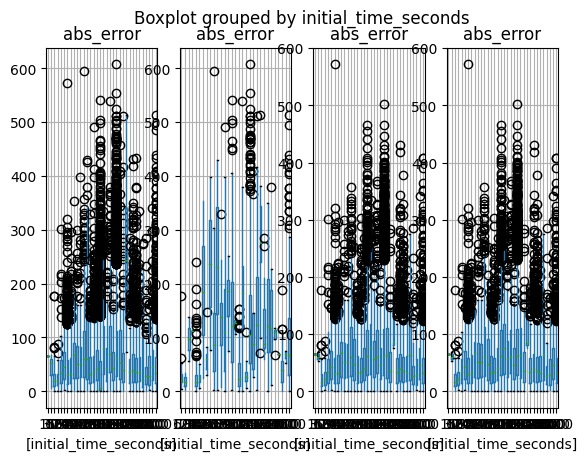

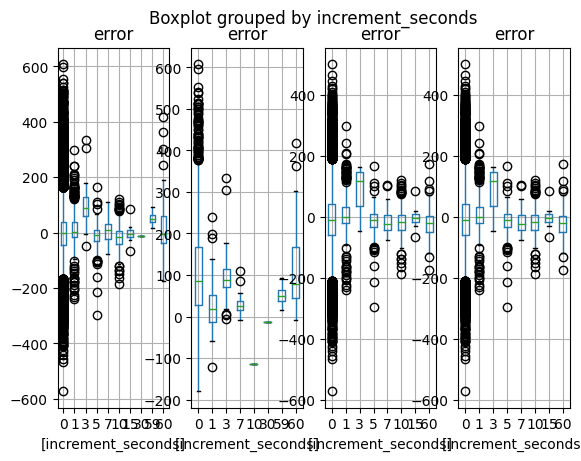

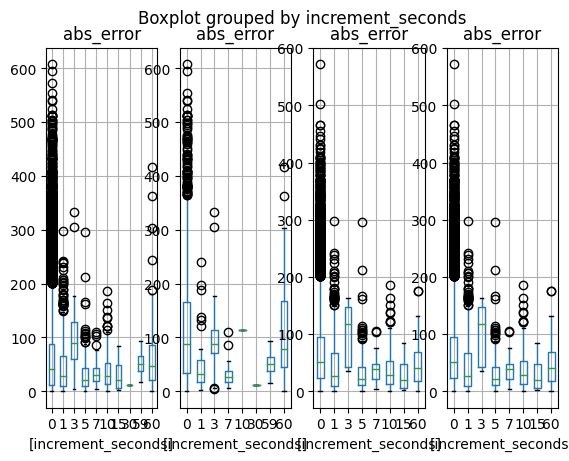

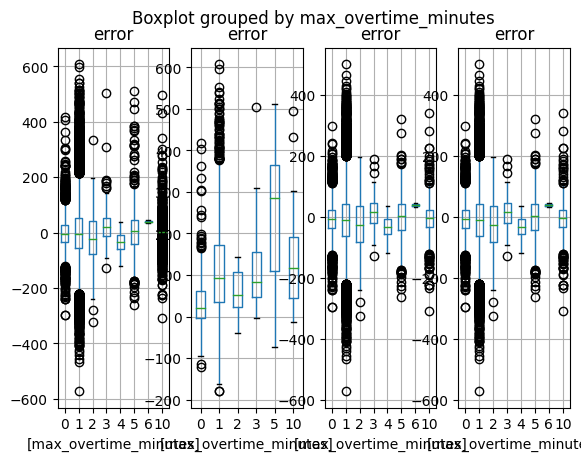

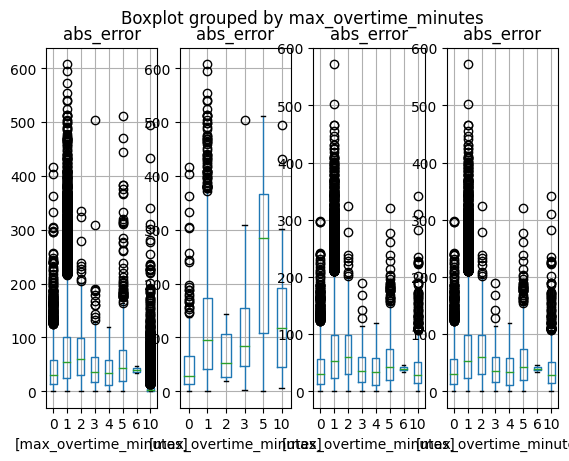

In [132]:
# fig, axes = plt.subplots(len(cats), 3)
more_mask = (data['rating'] > 1500)
less_mask = (data['rating'] < 1500)
both_mask = ~more_mask & ~less_mask

for i, check in enumerate(cats):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    data[[check, 'error']].boxplot(by=check, ax=axes[0])
    data[less_mask][[check, 'error']].boxplot(by=check, ax=axes[1])
    data[more_mask][[check, 'error']].boxplot(by=check, ax=axes[2])
    data[more_mask][[check, 'error']].boxplot(by=check, ax=axes[3])
    fig, axes = plt.subplots(nrows=1, ncols=4)
    data[[check, 'abs_error']].boxplot(by=check, ax=axes[0])
    data[less_mask][[check, 'abs_error']].boxplot(by=check, ax=axes[1])
    data[more_mask][[check, 'abs_error']].boxplot(by=check, ax=axes[2])
    data[more_mask][[check, 'abs_error']].boxplot(by=check, ax=axes[3])

In [211]:
data[data['abs_error'] > 120][less_mask][['pred', 'rating', 'error', 'abs_error']]

C:\Users\Bina4\AppData\Local\Temp\ipykernel_756\614806475.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['abs_error'] > 120][less_mask][['pred', 'rating', 'error', 'abs_error']]


,pred,rating,error,abs_error
game_id,,,,
165,1530.139282,1388,142.139282,142.139282
178,1677.223633,1493,184.223633,184.223633
203,1437.541382,1310,127.541382,127.541382
379,1420.256104,1241,179.256104,179.256104
519,1573.454224,1297,276.454224,276.454224
...,...,...,...,...
72286,1612.094971,1353,259.094971,259.094971
72390,1620.672974,1248,372.672974,372.672974
72412,1603.069824,1286,317.069824,317.069824


In [213]:
data[(error > 200) & ~(np.abs(data['bot_rating'] - data['rating']) > 150)]

,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_rating,bot_name,rating,abs_error,pred,error
game_id,,,,,,,,,,,,,,,,,
14809,bobcubed,regular,STANDARD,1,2022-08-02 17:03:09,NWL20,1200,0,RATED,1,617.384555,1632,BetterBot,1522,226.840454,1748.840454,226.840454
22301,BetterBot,regular,STANDARD,1,2022-09-13 06:35:16,NWL20,1200,0,RATED,1,688.951426,1624,BetterBot,1490,209.416382,1699.416382,209.416382
32044,BetterBot,regular,STANDARD,0,2022-08-25 22:41:13,NWL20,1800,0,CASUAL,1,883.200923,1631,BetterBot,1490,218.630737,1708.630737,218.630737
32242,BetterBot,regular,STANDARD,1,2022-09-17 15:45:16,CSW21,1800,0,RATED,1,542.550629,1934,BetterBot,1786,218.087280,2004.087280,218.087280
34316,QueenE,regular,STANDARD,0,2022-08-25 22:26:01,NWL20,1800,0,CASUAL,1,910.125160,1631,BetterBot,1490,226.768311,1716.768311,226.768311
35942,QueenE,regular,STANDARD,0,2022-08-06 02:51:27,NWL20,1800,0,CASUAL,1,707.539656,1666,BetterBot,1518,205.280640,1723.280640,205.280640
60460,BetterBot,regular,STANDARD,1,2022-08-25 22:09:44,NWL20,1800,0,CASUAL,1,539.365983,1624,BetterBot,1490,205.621460,1695.621460,205.621460
64713,jadeite,regular,STANDARD,1,2022-08-28 16:24:10,CSW21,1200,0,RATED,1,557.675871,1951,BetterBot,1813,230.913818,2043.913818,230.913818
67816,BetterBot,regular,STANDARD,0,2022-08-21 13:26:16,NWL20,1200,0,RATED,1,690.190875,1656,BetterBot,1528,208.977905,1736.977905,208.977905


In [185]:
data[(np.abs(data['bot_rating'] - data['rating']) > 400) & (data['abs_error'] > -1)]

,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,bot_rating,bot_name,rating,abs_error,pred,error
game_id,,,,,,,,,,,,,,,,,
4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141,1936,BetterBot,1473,85.788208,1387.211792,-85.788208
30,ji1222,regular,STANDARD,0,2022-09-15 21:23:57,CSW21,900,0,CASUAL,1,785.886790,2202,HastyBot,1712,123.237793,1835.237793,123.237793
39,ji1222,regular,STANDARD,1,2022-09-20 23:29:12,CSW21,900,0,CASUAL,1,870.416095,2150,HastyBot,1712,164.063477,1876.063477,164.063477
59,BetterBot,regular,STANDARD,0,2022-08-31 00:30:37,CSW21,1200,0,CASUAL,1,781.211562,2024,BetterBot,1513,124.071411,1637.071411,124.071411
95,BetterBot,rapid,STANDARD,0,2022-09-03 13:59:09,CSW21,780,0,CASUAL,1,561.906055,1916,BetterBot,1332,56.444214,1388.444214,56.444214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72703,BetterBot,rapid,TIME,0,2022-08-09 19:50:27,CSW21,600,0,CASUAL,1,665.512711,1934,BetterBot,1500,37.238281,1462.761719,-37.238281
72734,HastyBot,regular,STANDARD,0,2022-09-05 07:46:02,CSW21,1200,0,RATED,1,454.252302,2215,HastyBot,1233,3.388550,1229.611450,-3.388550
72738,Shahjahan,regular,STANDARD,0,2022-08-24 14:45:56,CSW21,900,0,RATED,1,410.583808,2073,STEEBot,1651,36.879150,1687.879150,36.879150


In [168]:
new_prediction = prediction.copy()
new_prediction[(data['abs_error'] > 120) & less_mask] = new_prediction[(data['abs_error'] > 120) & less_mask] -  50
new_prediction[(data['abs_error'] > 120) & less_mask]

game_id
165      1480.139282
178      1627.223633
203      1387.541382
379      1370.256104
519      1523.454224
            ...     
72286    1562.094971
72390    1570.672974
72412    1553.069824
72684    1583.517700
72772    1487.861450
Length: 916, dtype: float32

In [169]:
mean_squared_error(n_ratings, new_prediction, squared=False)

84.97255864199569

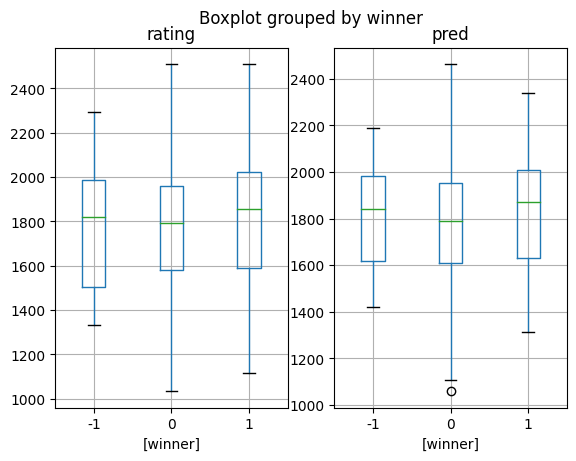

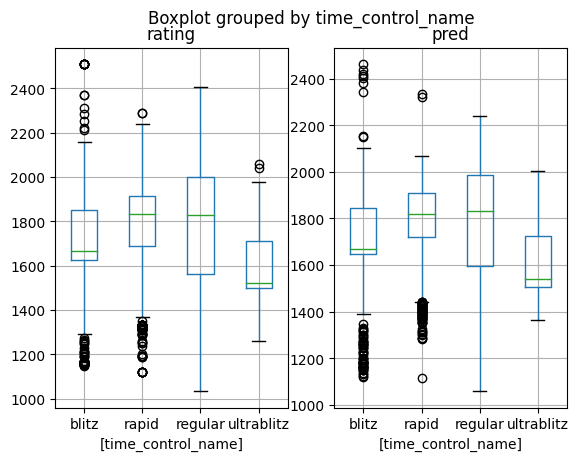

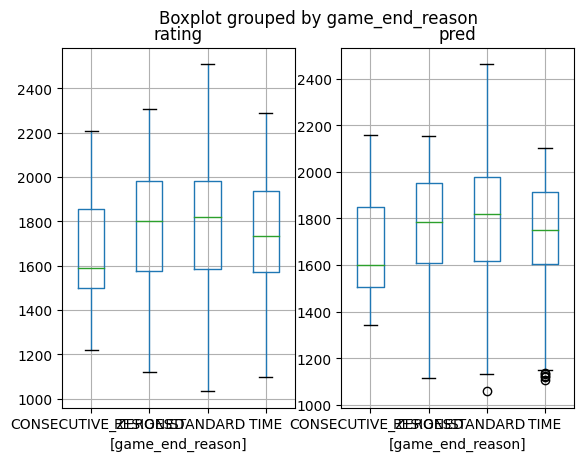

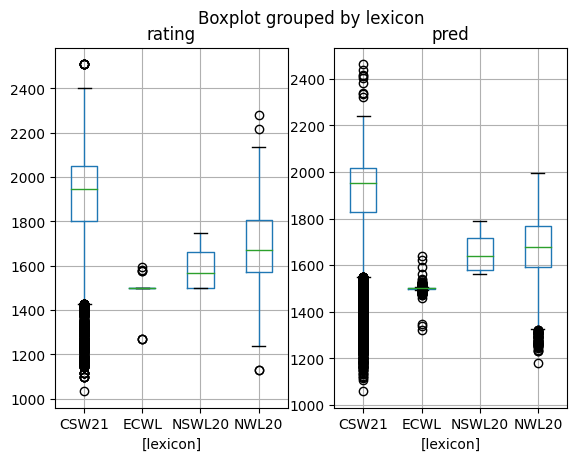

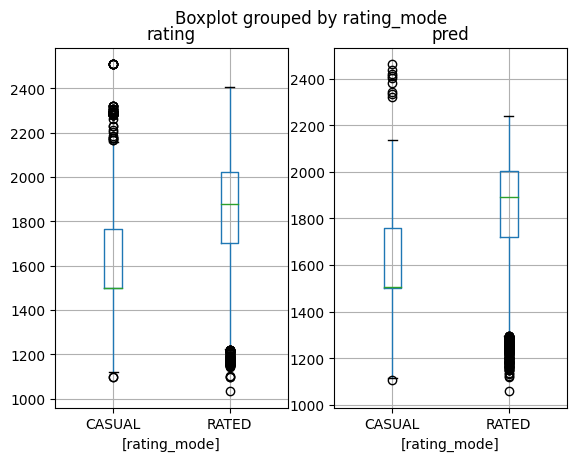

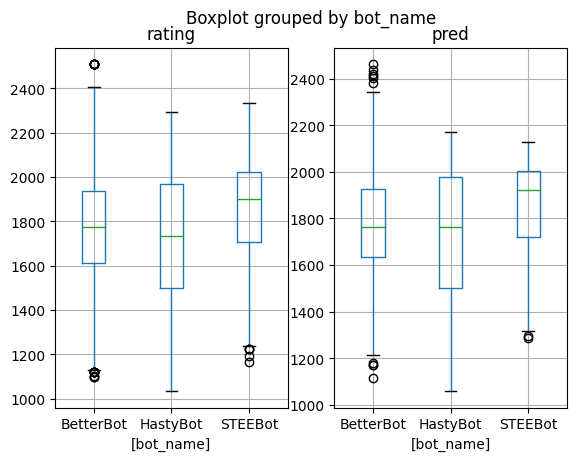

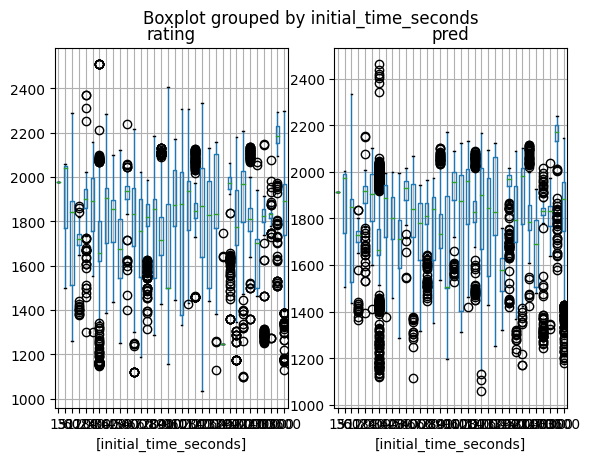

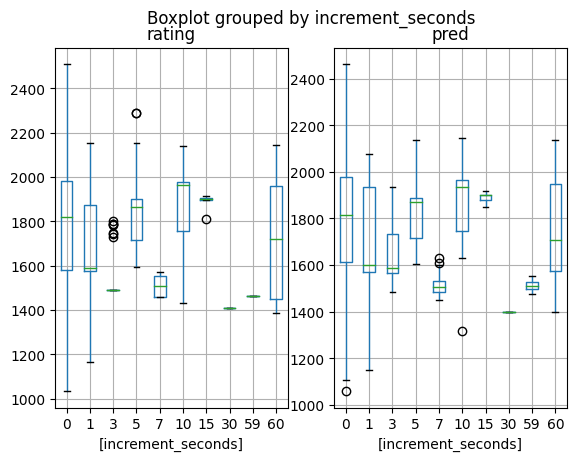

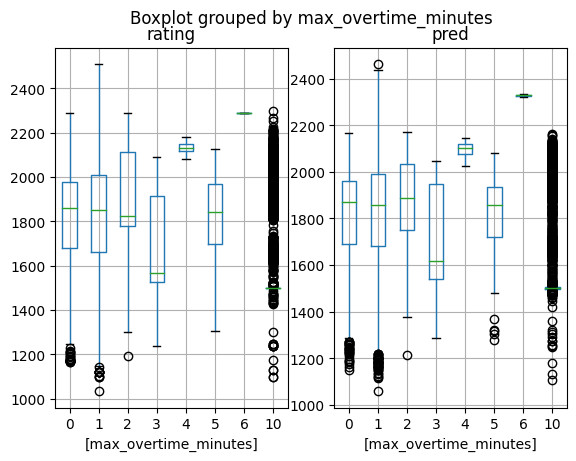

In [116]:
# fig, axes = plt.subplots(len(cats), 3)
# mask = (data['rating'] < 1600) & (data['rating'] > 1400)
for i, check in enumerate(cats):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    data[[check, 'rating']].boxplot(by=check, ax=axes[0])
    data[[check, 'pred']].boxplot(by=check, ax=axes[1])

In [117]:
features

array(['initial_time_seconds', 'max_overtime_minutes',
       'game_duration_seconds', 'bot_rating',
       'a_turn_type_Challenge__mean', 'a_turn_type_Pass__sum_values',
       'a_turn_type_Timeout__mean', 'a_Z__mean', 'p_points__sum_values',
       'p_points__median', 'p_points__mean', 'p_points__root_mean_square',
       'p_score__root_mean_square', 'p_score__maximum',
       'p_turn_type_End__mean', 'p_turn_type_Exchange__sum_values',
       'p_turn_type_Pass__mean', 'p_turn_type_Pass__standard_deviation',
       'p_turn_type_Play__mean', 'p_A__maximum', 'p_I__maximum',
       'p_.__median', 'p_move_len__mean', 'p_move_len__root_mean_square',
       'p_jokers_num__sum_values', 'p_jokers_num__mean',
       'b_turn_type_End__mean', 'b_e__standard_deviation', 'b_l__mean',
       'b_move_len__sum_values', 'b_jokers_num__mean',
       'time_control_name_blitz', 'time_control_name_rapid',
       'time_control_name_regular', 'lexicon_CSW21', 'rating_mode_CASUAL',
       'bot_name_BetterBo

In [18]:
n_data

,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,...,p_.__median,p_move_len__mean,p_move_len__root_mean_square,p_jokers_num__sum_values,p_jokers_num__mean,b_turn_type_End__mean,b_e__standard_deviation,b_l__mean,b_move_len__sum_values,b_jokers_num__mean
game_id,,,,,,,,,,,,,,,,,,,,,
1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,...,0.0,3.857143,4.191829,2.0,0.142857,0.000000,0.000000,0.0,60.0,0.000000
3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,...,0.0,4.357143,4.652188,1.0,0.071429,0.000000,0.000000,0.0,57.0,0.076923
4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,...,1.0,2.928571,3.218252,0.0,0.000000,0.000000,0.000000,0.0,76.0,0.066667
5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,...,0.0,3.375000,3.553168,0.0,0.000000,0.000000,0.249444,0.0,67.0,0.133333
6,HivinD,regular,STANDARD,0,2022-08-21 14:56:35,CSW21,900,0,RATED,1,...,0.5,4.750000,4.804512,0.0,0.000000,0.076923,0.000000,0.0,66.0,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72767,BetterBot,regular,TIME,0,2022-09-05 04:35:56,CSW21,3600,0,CASUAL,1,...,0.0,3.500000,3.840573,1.0,0.062500,0.000000,0.000000,0.0,73.0,0.062500
72770,HastyBot,regular,TIME,0,2022-09-04 00:13:24,CSW21,3600,0,RATED,1,...,1.0,3.187500,3.363406,1.0,0.062500,0.000000,0.242061,0.0,79.0,0.062500
72771,HastyBot,regular,STANDARD,0,2022-09-19 03:28:44,ECWL,900,0,CASUAL,10,...,1.0,4.250000,4.527693,0.0,0.000000,0.000000,0.000000,0.0,59.0,0.133333


In [74]:
t_data = regressor[:-1].transform(n_data)
X1, X2, y1, y2 = train_test_split(t_data, n_ratings, test_size=0.95, random_state=42)

classifer =XGBClassifier(random_state=0,)
classifer.fit(X1, (y1 < 1600).astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [139]:
c_pred = classifer.predict(t_data)
accuracy_score(c_pred, n_ratings < 1500)

0.769966276532434

In [76]:
X2['bigger'] = classifer.predict(X2)

In [77]:
new_regressor = XGBRegressor(random_state=0,
                                        max_depth=7, min_child_weight=1,
                                        gamma=0,
                                        subsample=1, colsample_bytree=1,
                                        reg_alpha=0.00005, reg_lambda=1,
                                        learning_rate=np.sqrt(3)/10)
new_regressor.fit(X2, y2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.17320508075688773,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [78]:
test = t_data.assign(**{'bigger': classifer.predict(t_data)})
new_prediction = new_regressor.predict(test)

In [79]:
mean_squared_error(n_ratings, new_prediction, squared=False)

87.00810678213213

In [80]:
cv_res = cross_validate(new_regressor, X2, y2, cv=5,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True,)

In [81]:
pd.DataFrame(cv_res).mean()

fit_time         3.262230
score_time       0.019779
test_score    -105.693440
train_score    -84.988276
dtype: float64